In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras. preprocessing.sequence import pad_sequences
print(tf.__version__)

from sklearn.model_selection import train_test_split

2.4.1


In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import collections

In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

print(train.head())
print(test.head())

   id                                        raw_address  \
0   0  jl kapuk timur delta sili iii lippo cika 11 a ...   
1   1                                 aye, jati sampurna   
2   2               setu siung 119 rt 5 1 13880 cipayung   
3   3                               toko dita, kertosono   
4   4                                      jl. orde baru   

                                  POI/street  
0  /jl kapuk timur delta sili iii lippo cika  
1                                          /  
2                                     /siung  
3                                 toko dita/  
4                             /jl. orde baru  
   id                                    raw_address
0   0          s. par 53 sidanegara 4 cilacap tengah
1   1          angg per, baloi indah kel. lubuk baja
2   2                          asma laun, mand imog,
3   3  ud agung rej, raya nga sri wedari karanganyar
4   4                     cut mutia, 35 baiturrahman


In [4]:
print(train['raw_address'].sample(20))

98119              ice cream abdul wahab sia, no rf 11 rw 7
26084                      raya solo, bpr sapa dhana, jiwan
293960           ngestiharjo jl. sonop kidul 4 rt 1 kasihan
266271                            beng mobil jan, jend sudi
135830                   sema rt 6 rw 2 cilincing cilincing
233181    citra raya cluster pesona atlantis. jl. meditr...
182600               tris chem kebun jelambar pis, jelambar
165613                        jalin matra, raya jeng, lajuk
262844     babakan gg. m. yamin 4 77 rt 4 4 15118 tangerang
188769                 pacar kel gang ii, pacar keling kel.
223885                        satelit cell, kart 79 rembang
182337                  teluk kumai timur, perak utara kel.
48134                        villa wij, raya tretes, prigen
97800                   rudi motor, adi suci, muncan kopang
69089                                           dr muwa ii,
296169           es doger prima rasa haji san, penggilingan
66456                                   

In [5]:
# creating regex to split raw_address into words
my_regex = '\s|,\s|,|\.|:'

# POI

## Splitting Data - POI

In [6]:
raw_df_withPOI = train[train['POI/street'].str.contains('.+(?=/)')==True]
raw_df_withPOI['POI/street'] = raw_df_withPOI['POI/street'].str.extract(r'(.+)(?=/)')
raw_df_withPOI.head()

<ipython-input-6-b6388c6d3dde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_withPOI['POI/street'] = raw_df_withPOI['POI/street'].str.extract(r'(.+)(?=/)')


,id,raw_address,POI/street
3,3,"toko dita, kertosono",toko dita
5,5,"raya samb gede, 299 toko bb kids",toko bb kids
10,10,"cikahuripan sd neg boj 02 klap boj, no 5 16877",sd negeri bojong 02
11,11,"yaya atohar,",yayasan atohariyah
15,15,"kampung.gudang areng,desa:anyer, kecamatan:any...",gudang areng


In [7]:
# turning raw_address and POI/street columns into lists of strings; discarding id and index column
list_of_addresses_withPOI = [*raw_df_withPOI['raw_address']]
print(list_of_addresses_withPOI[:5])

list_of_POI = [*raw_df_withPOI['POI/street']]

['toko dita, kertosono', 'raya samb gede, 299 toko bb kids', 'cikahuripan sd neg boj 02 klap boj, no 5 16877', 'yaya atohar,', 'kampung.gudang areng,desa:anyer, kecamatan:anyar, kabupaten: serang, belakang bca anyar']


## Creating labels_binary_POI

[3, 7, 10, 2, 12]
30
121491


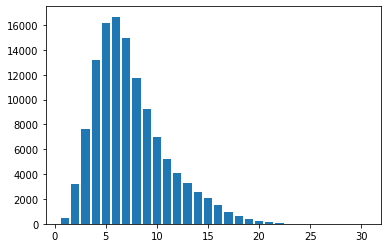

[2, 3, 4, 2, 2]
23
121491


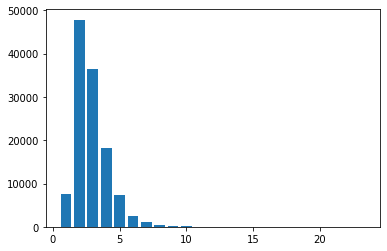

In [8]:
# plotting distribution of length of raw_addresses and POI
from Plot_distribution import plotDistribution

plotDistribution(list_of_addresses_withPOI)
plotDistribution(list_of_POI)

In [9]:
max_length_address = 25   #len(max(raw_df_withPOI['raw_address']))
max_length_POI = 10       #len(max(raw_df_withPOI['POI/street']))

In [10]:
dictionary_POI = {}

In [11]:
# binary labels for all addresses in test.csv
from Binary_labels_and_dict import binary_labels_and_dict

labels_binary_POI, dictionary_POI = binary_labels_and_dict(list_of_addresses_withPOI, list_of_POI, dictionary_POI)

In [12]:
print(len(dictionary_POI))

# filter out words that contain only digits or have 0 characters from dictionary
from Binary_labels_and_dict import filter_dict

filtered_dict_POI = filter_dict(dictionary_POI)
print(len(filtered_dict_POI))

10205
10092


## Tokenizer and Padding - POI

In [13]:
trunc_type = 'post'
padding = 'post'
oov_tok="<OOV>"

print(type(list_of_addresses_withPOI))
sentences_to_tokenize = list_of_addresses_withPOI.copy()

print(type(sentences_to_tokenize))

print(len(list_of_addresses_withPOI))

sentences_to_tokenize.append(list_of_POI)
print(len(list_of_addresses_withPOI))
print(sentences_to_tokenize[:5])

<class 'list'>
<class 'list'>
121491
121491
['toko dita, kertosono', 'raya samb gede, 299 toko bb kids', 'cikahuripan sd neg boj 02 klap boj, no 5 16877', 'yaya atohar,', 'kampung.gudang areng,desa:anyer, kecamatan:anyar, kabupaten: serang, belakang bca anyar']


In [14]:
if len(list_of_addresses_withPOI) != len(list_of_POI):
  print(len(list_of_addresses_withPOI))
  print(len(list_of_POI))

In [15]:
# Tokenizing train_addresses and train_POI
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_to_tokenize)

word_index = tokenizer.word_index
print(len(word_index))
total_words = len(word_index)+1

# Tokenizing train_addresses & train_POI and Padding addresses
data_sequences = tokenizer.texts_to_sequences(list_of_addresses_withPOI)
padded = pad_sequences(data_sequences, maxlen=max_length_address, truncating=trunc_type, padding=padding)
print(padded[0])
print(padded.shape)

155943
[   6 7312 5187    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
(121491, 25)


In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(list_of_addresses_withPOI[1])

raya samb gede 299 toko bb kids ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
raya samb gede, 299 toko bb kids


## Train Test Split - POI

In [17]:
# train_test_split to get training and testing datasets
train_addresses_withPOI, test_addresses_withPOI, train_labels_POI, test_labels_POI = train_test_split(
padded, labels_binary_POI, test_size=0.20, random_state=42)

## Model building - POI

In [18]:
embedding_dim = 64
total_words = 200000

# basic model - no Bidirectional, LSTM, etc.
model_POI = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim, input_length=max_length_address),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(max_length_address, activation='sigmoid')
])
model_POI.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_POI.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 64)            12800000  
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 32)            10368     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 12,832,793
Trainable params: 12,832,793
Non-trainable params: 0
____________________________________________

In [19]:
# if train_padded.shape[0] != labels_binary_POI.shape[0]:
#   print('Training addresses and labels have different number of rows')

In [20]:
earlyStopping = EarlyStopping(monitor = 'val_acc', patience = 5)
modelCheckpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True)

num_epochs = 3

history = model_POI.fit(train_addresses_withPOI, train_labels_POI, epochs=num_epochs, validation_data=(test_addresses_withPOI, test_labels_POI), callbacks=[earlyStopping, modelCheckpoint])

Epoch 1/3
3038/3038 [==============================] - 338s 109ms/step - loss: 0.1564 - accuracy: 0.3631 - val_loss: 0.0748 - val_accuracy: 0.4664
Epoch 2/3
3038/3038 [==============================] - 329s 108ms/step - loss: 0.0612 - accuracy: 0.4533 - val_loss: 0.0640 - val_accuracy: 0.4120
Epoch 3/3
3038/3038 [==============================] - 329s 108ms/step - loss: 0.0419 - accuracy: 0.4733 - val_loss: 0.0634 - val_accuracy: 0.5315


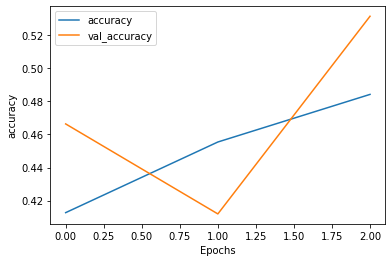

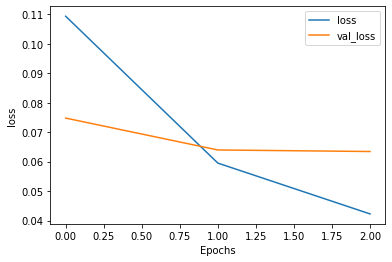

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## model_POI.predict

In [22]:
live_sequences = tokenizer.texts_to_sequences(test['raw_address'])
live_padded = pad_sequences(live_sequences, maxlen=max_length_address, truncating=trunc_type, padding=padding)
print(live_padded.shape)

from Predict_and_convert_to_words import predict_and_convert_to_words

live_labels_POI = predict_and_convert_to_words(live_padded, test['raw_address'], 0.5, filtered_dict_POI, model_POI)
print(live_labels_POI[:5])
print(test['raw_address'][:5])

(50000, 25)
['sinar', 'kelapa', 'asma laundry mandiri', 'ud agung rejeki', 'cut']
0            s. par 53 sidanegara 4 cilacap tengah
1            angg per, baloi indah kel. lubuk baja
2                            asma laun, mand imog,
3    ud agung rej, raya nga sri wedari karanganyar
4                       cut mutia, 35 baiturrahman
Name: raw_address, dtype: object


# Street (ST)

## Splitting Data - ST

In [23]:
raw_df_withST = train[train['POI/street'].str.contains('(?<=/).+')==True]
raw_df_withST['POI/street'] = raw_df_withST['POI/street'].str.extract(r'(?<=/)(.+)')
raw_df_withST.head()

<ipython-input-23-e80007895fc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_withST['POI/street'] = raw_df_withST['POI/street'].str.extract(r'(?<=/)(.+)')


,id,raw_address,POI/street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,jl kapuk timur delta sili iii lippo cika
2,2,setu siung 119 rt 5 1 13880 cipayung,siung
4,4,jl. orde baru,jl. orde baru
5,5,"raya samb gede, 299 toko bb kids",raya samb gede
6,6,"kem mel raya, no 4 bojong rawalumbu rt 1 36 ra...",kem mel raya


In [24]:
# turning raw_address and POI/street columns into lists of strings; discarding id and index column
list_of_addresses_withST = [*raw_df_withST['raw_address']]
print(list_of_addresses_withST[:5])

list_of_ST = [*raw_df_withST['POI/street']]

['jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat', 'setu siung 119 rt 5 1 13880 cipayung', 'jl. orde baru', 'raya samb gede, 299 toko bb kids', 'kem mel raya, no 4 bojong rawalumbu rt 1 36 rawalumbu']


## Creating labels_binary_ST

[13, 8, 4, 7, 11]
30
229857


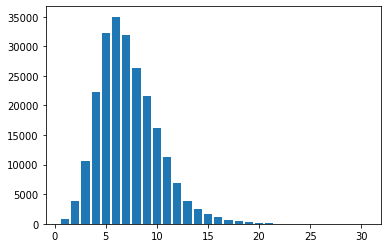

[8, 1, 4, 3, 3]
17
229857


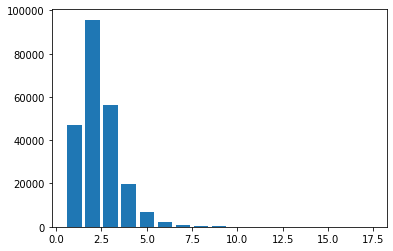

In [25]:
# plotting distribution of length of raw_addresses and ST
plotDistribution(list_of_addresses_withST)
plotDistribution(list_of_ST)

In [26]:
max_length_address = 25   #len(max(raw_df_withST['raw_address']))
max_length_ST = 10       #len(max(raw_df_withST['POI/street']))

In [27]:
dictionary_ST = {}

In [28]:
# binary labels for training set
labels_binary_ST, dictionary_ST = binary_labels_and_dict(list_of_addresses_withST, list_of_ST, dictionary_ST)

In [29]:
print(len(dictionary_ST))

filtered_dict_ST = filter_dict(dictionary_ST)
print(len(filtered_dict_ST))

3494
3483


## Tokenizer and Padding - ST

In [30]:
trunc_type = 'post'
padding = 'post'
oov_tok="<OOV>"

print(type(list_of_addresses_withST))
sentences_to_tokenize = list_of_addresses_withST.copy()

print(type(sentences_to_tokenize))
# train_ST_sentences = []

print(len(list_of_addresses_withST))

sentences_to_tokenize.append(list_of_ST)
print(len(list_of_addresses_withST))
print(sentences_to_tokenize[:5])

<class 'list'>
<class 'list'>
229857
229857
['jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat', 'setu siung 119 rt 5 1 13880 cipayung', 'jl. orde baru', 'raya samb gede, 299 toko bb kids', 'kem mel raya, no 4 bojong rawalumbu rt 1 36 rawalumbu']


In [31]:
if len(list_of_addresses_withST) != len(list_of_ST):
  print(len(list_of_addresses_withPOI))
  print(len(list_of_POI))

In [33]:
# Tokenizing train_addresses and train_ST
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_to_tokenize)

word_index = tokenizer.word_index
print(len(word_index))
total_words = len(word_index)+1

# Tokenizing train_addresses & train_POI and Padding addresses
data_sequences = tokenizer.texts_to_sequences(list_of_addresses_withST)
padded = pad_sequences(data_sequences, maxlen=max_length_address, truncating=trunc_type, padding=padding)

print(padded[0])
print(padded.shape)

152356
[   9  260   12  853 5464   34 2647  555   29   48 6095  144  329    0
    0    0    0    0    0    0    0    0    0    0    0]
(229857, 25)


In [35]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(list_of_addresses_withST[1])

setu siung 119 rt 5 1 13880 cipayung ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
setu siung 119 rt 5 1 13880 cipayung


## Train Test Split - ST

In [ ]:
# train_test_split to get training and testing datasets
train_addresses_withST, test_addresses_withST, train_labels_ST, test_labels_ST = train_test_split(
padded, labels_binary_ST, test_size=0.20, random_state=42)

print(len(train_addresses_withST))
print(len(train_labels_ST))

## Model building - ST

In [ ]:
embedding_dim = 64

# basic model - no Bidirectional, LSTM, etc.
model_ST = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim, input_length=max_length_address),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(max_length_address, activation='sigmoid')
])
model_ST.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_ST.summary()

In [ ]:
if train_padded.shape[0] != labels_binary_ST.shape[0]:
  print('Training addresses and labels have different number of rows')

In [ ]:
num_epochs = 10

history = model_ST.fit(train_addresses_withST, train_labels_ST, epochs=num_epochs, validation_data=(test_addresses_withST, test_labels_ST), callbacks=[earlyStopping, modelCheckpoint])

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## model_ST.predict

In [ ]:
live_sequences_ST = tokenizer.texts_to_sequences(test['raw_address'])
live_padded_ST = pad_sequences(live_sequences_ST, maxlen=max_length_address, truncating=trunc_type, padding=padding)
print(live_padded_ST.shape)

In [ ]:
live_labels_ST = predict_and_convert_to_words(live_padded_ST, test['raw_address'], threshold=0.5, filtered_dict_ST, model_ST)
print(live_labels_ST[:5])
print(test['raw_address'][:5])

# Combine results of POI and ST - POI/Street column

In [ ]:
print('live_labels_ST is type: ' + str(type(live_labels_ST)))
print('live_labels_POI is type: ' + str(type(live_labels_POI)))

# check if live_labels_ST and _POI have same number of elements
if len(live_labels_ST) != len(live_labels_POI):
  print('live_labels_ST and _POI have different number of elements')

In [ ]:
test['POI'] = live_labels_POI
test['Street'] = live_labels_ST

print(test.head())

test['POI/Street'] = test.POI.cat(test.Street, sep='/')
print(test.head())

submission = test[['id', 'POI/Street']]
print(submission)

submission.to_csv('submission.csv', index=False)